# Data processing

In this notebook, I'm collecting the data for the two cities in Peru and Puerto Rico and then combinting the dengue data with other datasets including precipitation, population, and temperature.

## Import libraries

I'll import the libraries needed for combing the various data files and create testing and training data.

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## Data for Iquitos, Peru

In this specific section, I'll work with the data for Iquitos, Peru and create the data ready for model creation.

### Load datasets

I'm going to load in data files for `dengue`, `population` and `environment`.

In [4]:
dengue = pd.read_csv("data/iquitos/dengue_data.csv")
population = pd.read_csv("data/iquitos/population_data.csv")
environment = pd.read_csv("data/iquitos/environment_data.csv")

### Extract data from `dengue_data`

I'll create new columns of `date` which includes year and month, and two other columns `year` and `month` for making it easier to combine with other data files.

In [5]:
dengue_peru_rdengueefined = dengue[["week_start_date", "total_cases"]]
dates = dengue["week_start_date"].str.split('-')
dengue = dengue.assign(date = [year + "-" + month for year, month, _ in dates])
dengue = dengue.assign(year = [int(year) for year, _, _ in dates])
dengue = dengue.assign(month = [int(month) for _, month, _ in dates])
dengue.drop(["week_start_date"], axis = 1)
dengue = dengue[['date', 'year', 'month', 'total_cases']]

I'll now group all the data based on the data and now the `total_cases` will be the total for each month.

In [6]:
dengue = dengue.groupby(['date', 'year', 'month'], as_index=False).sum()

In [109]:
import matplotlib.pyplot as plt
%matplotlib inline

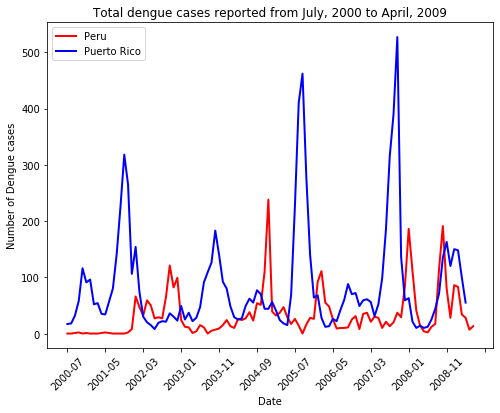

In [110]:
plt.figure(figsize = (8, 6))
plt.plot(dengue_peru_refined['date'], dengue_peru_refined['total_cases'], color = 'red', linewidth = 2, label = 'Peru')
plt.xticks(np.arange(0, 120, 10), rotation = 45)
plt.xlabel("Date")
plt.ylabel("Number of Dengue cases")
plt.title("Total dengue cases reported from July, 2000 to April, 2009")
plt.legend()
plt.show()

In [123]:
# Population datasets
peru_population = pd.read_csv("Population_data/iquitos_population_data.csv")

In [124]:
peru_population = peru_population.rename({"Year": 'year', "Estimated_population": "population"}, axis = 1)

In [125]:
dengue_peru_refined = dengue_peru_refined.merge(peru_population, on = 'year', how='left')